In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','interp_delay')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [40]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '1'
# net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise'
data_folder = 'data/rnn/multitask/stepnet/lr' #8/2/21

m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

r1 = 18
r2 = 19
task_list = [rules_dict['all'][r1],rules_dict['all'][r2]]
epoch_list = ['delay1','delay1']

t_set = [0,0]

In [41]:
from tools_lnd import gen_trials_from_model_dir, same_mov_inds

rule1 = rules_dict['all'][r1]
rule2 = rules_dict['all'][r2]

trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = True)
trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = True)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = True)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

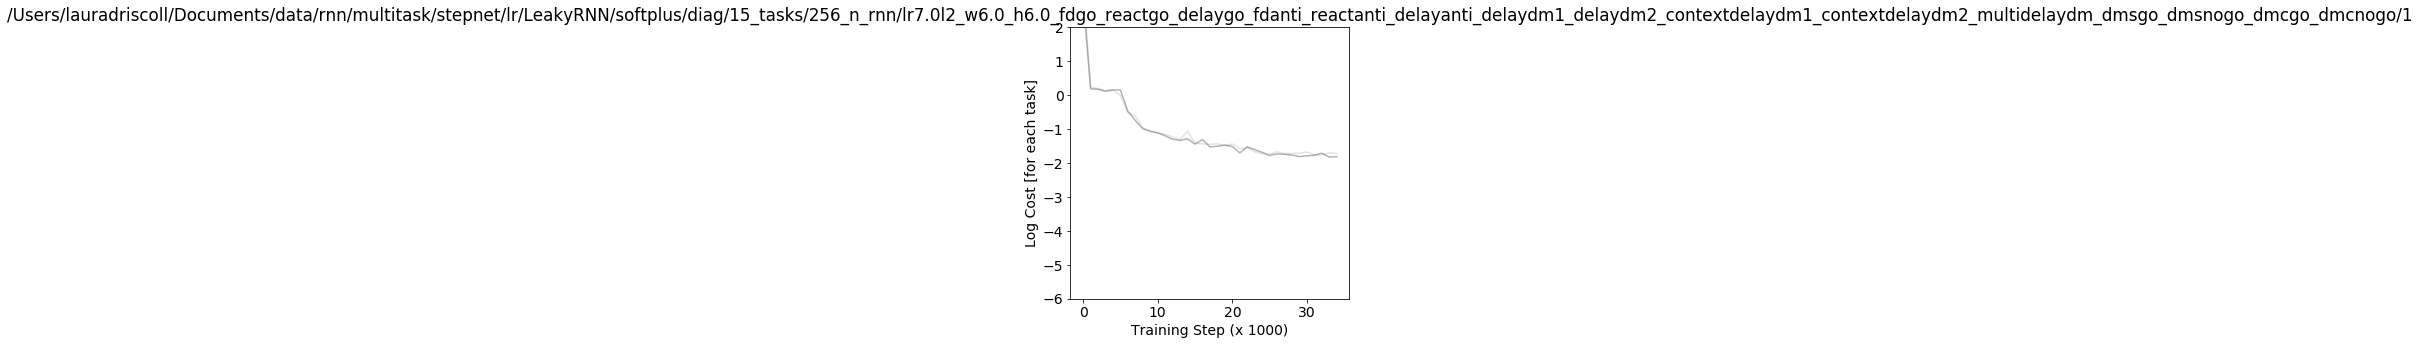

In [42]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

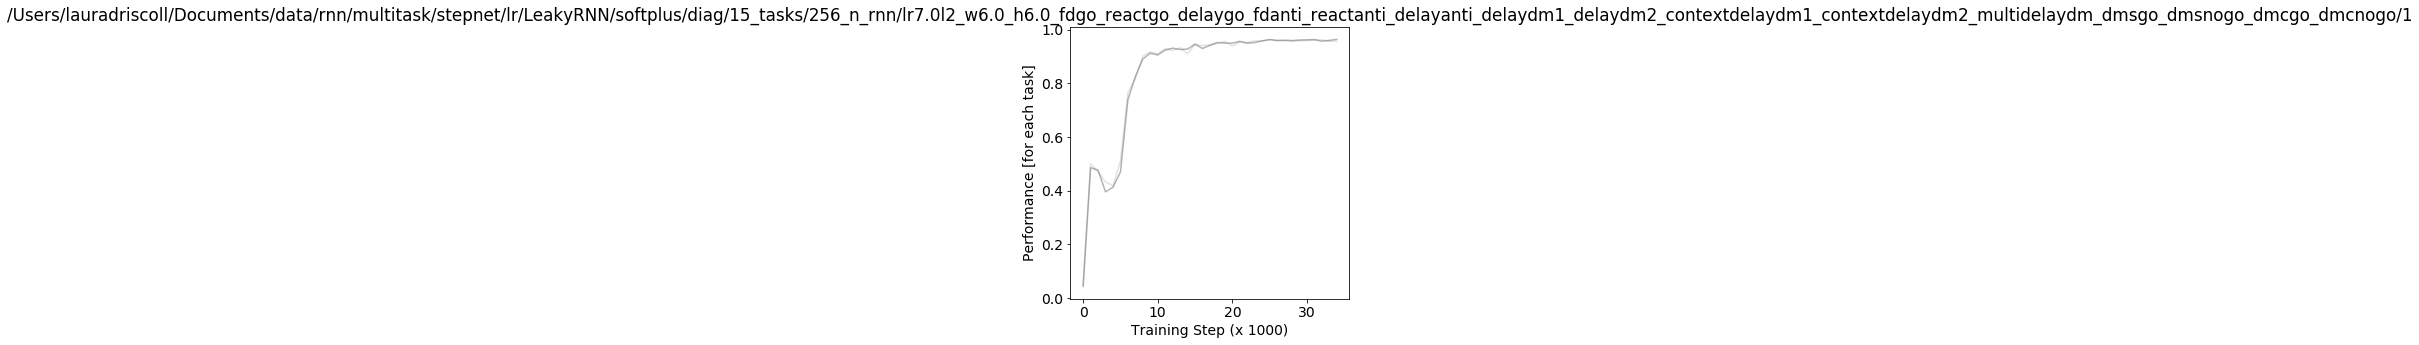

In [43]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Performance [for each task]')
#     plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [44]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [45]:
model = Model(m)
rule = task_list[0]
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [46]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [47]:
def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

In [48]:
def plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 4, al = .6, 
                        linestyle = '-',c = 'k', dim3 = 'True'):
    
    alpha = hparams['dt']/hparams['tau']
    h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
    
    if sum(np.diff(np.sum(x_t,axis = 1)))>0:
        e_start = np.where(np.diff(np.sum(x_t,axis = 1))>0)[0][0]+1
    else:
        e_start = 0
            
    jitter = np.dot(h_t[e_start:,:],D_use)
    
    if dim3 == 'True':
        ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = lw,alpha = al)
    else:
        ax.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = lw,alpha = al)
        ax.plot(jitter[:,0],jitter[:,1],'-',c = 'k',linewidth = .3,alpha = 1)
        ax.plot(jitter[-1,0],jitter[-1,1],'x',c = 'k',markeredgewidth = 2,alpha = 1)
        
    return h_t

In [49]:
def interp_h_tasks(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 30,linestyle = ['-',':']):
    fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
    ax = fig.add_subplot(111)
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('viridis')

    if len(D_use)==0:
        ri_axs = 0
        axs = 'pca_h'
        epoch = epoch_list[0]
        rule = rules_dict['all'][ri_set[ri_axs]]
        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
        f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
        filename = os.path.join(save_dir,f+'.npz')
        D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[0]], epoch, axs = axs, clust = 'False')

    epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    trial_set = [trial1,trial2]

    T_inds1 = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]

    T_inds2 = get_T_inds(trial2,epoch_list[1])
    inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]

    del_inputs = inputs_2 - inputs_1

    for ri in [1,0]:
        rule = rules_dict['all'][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch)
        h_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

        for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
            ti = big_stim_trials[ti_ind]

            trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

            h0 = h_epoch[ti,0,:]
            x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap_stim(ti/np.shape(x)[1]),
                     linewidth = 8,label = trial_label)
            plt.plot(jitter[:,0],jitter[:,1],c = cmap_stim(ti/np.shape(x)[1]),
                     linewidth = 8,alpha = .5, linestyle = linestyle[ri])
    #         plt.plot(jitter[:,0],jitter[:,1],'-',c = c_discrete[ri],linewidth = 3,alpha = .5)

    for step_i in range(n_interp):

        step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
        x_t = np.matlib.repmat(step_inputs,n_steps,1)
        h0 = h_epoch[trial_num[ri],0,:]

        plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 1, al = .3, 
                            linestyle = '-',c = cmap_grad(step_i/n_interp), dim3 = 'False')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')

    tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
    step_file='interp_h'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = axes_label1+'_'+axes_label2+'_'+epoch+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax

In [50]:
def get_h_epoch(m,trial,epoch,t_num):
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = x[:,t_num,T_inds]
    return h_epoch

In [51]:
def plot_jitter_arrow(jitter,c,linewidth = 1.2,alpha = .1):
    plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = linewidth,alpha = alpha)

    x_end = jitter[-1,0]
    y_end = jitter[-1,1]
    del_x = jitter[-1,0] - jitter[-2,0]
    del_y = jitter[-1,1] - jitter[-2,1]
    
    plt.arrow(x_end,y_end, del_x, del_y, fc = c, ec = c, shape='full', lw=0, 
                          length_includes_head=True, head_width=.1)
    
def plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams, linewidth = 1.2,alpha = .1):
    
    cmap_discrete = ['navy','gold']
    
    c = cmap_discrete[0]
    h_t = vanilla_run_with_h0(params, x_t1_big, h0, hparams)
    jitter = np.dot(h_t,D_fp_qr)
    plot_jitter_arrow(jitter,c,linewidth = linewidth,alpha = alpha)

    c = cmap_discrete[1]
    h_t = vanilla_run_with_h0(params, x_t2_big, h0, hparams)
    jitter = np.dot(h_t,D_fp_qr)
    plot_jitter_arrow(jitter,c,linewidth = linewidth,alpha = alpha)
    
def gen_trial_set(ri_set):
    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

def gen_inputs(trial_set,epoch_list,trial_num,n_steps):
    
    trial_set_i = 0
    trial1 = trial_set[trial_set_i]
    T_inds = get_T_inds(trial1,epoch_list[trial_set_i])
    x_t1 = trial1.x[T_inds[0],trial_num[trial_set_i],:]
    x_t1_big = np.matlib.repmat(x_t1,n_steps,1)
    
    trial_set_i = 1
    trial2 = trial_set[trial_set_i]
    x_t2 = trial2.x[T_inds[0],trial_num[trial_set_i],:]
    x_t2_big = np.matlib.repmat(x_t2,n_steps,1)
    
    return x_t1, x_t2, x_t1_big, x_t2_big

def gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num):

    h_A = get_h_epoch(m,trial_set[ri_axs],epoch_list[ri_axs],trial_num[ri_axs])
    h_end = h_A[:,-1] - h_A[:,0]
    h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch_list[1-ri_axs],trial_num[1-ri_axs])
    h_diff = h_B[:,-1] - h_A[:,-1]

    D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
    D_fp_qr,_ = LA.qr(D_fp)
    
    return D_fp_qr

def get_fp_file(m, ri_set, trial_set, epoch_list, trial_num, trial_i):
    
    step_file = 'interp_tasks_small_init_mov'
    q_tol_name = 'tol_q_e_6.0'

    if trial_i==0:
        step_i = 0
    elif trial_i==1:
        step_i = 19
        
    f = get_interp_filename(trial_set[0],trial_set[1],[epoch_list[0],epoch_list[0]],trial_num)
    save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
    fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
    
    return fp_struct

In [52]:
from mpl_toolkits.mplot3d import Axes3D

def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                        q_thresh = 1e-5,linestyle = ['-',':'],al = .3,lw = 3):

    fig = plt.figure(figsize=(5,10),tight_layout=True,facecolor='white')
    ax_fps = fig.add_subplot(212, projection='3d');
    plt.rcParams.update({'font.size': 12})
    ax_h = fig.add_subplot(211)
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('viridis')
    step_file = 'interp_tasks_small_init_mov'
    q_tol_name = 'tol_q_e_6.0'

    # if len(D_use)==0:
    ri_axs = 0
    axs = 'pca_h'
    epoch = epoch_list[ri_axs]
    rule = rules_dict['all'][ri_set[ri_axs]]
    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
    f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
    filename = os.path.join(save_dir,f+'.npz')
    D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[ri_axs]], epoch, axs = axs, clust = 'False')

    epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0]
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    for ri in [1,0]:
        rule = rules_dict['all'][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

        for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
            ti = big_stim_trials[ti_ind]

            trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

            h0 = h_epoch[ti,0,:]
            x_t = trial.x[:T_inds[-1],ti,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            jitter = np.dot(h_t,D_use)

            plt.sca(ax_h)
            plt.plot(jitter[-1,0],jitter[-1,1],'x',markersize = 10,c = cmap_stim(ti/np.shape(x)[1]),
                     linewidth = 8,label = trial_label)
            plt.plot(jitter[T_inds,0],jitter[T_inds,1],c = cmap_stim(ti/np.shape(x)[1]),
                     linewidth = 5,alpha = .5, linestyle = linestyle[ri])
    #         plt.plot(jitter[:,0],jitter[:,1],'-',c = c_discrete[ri],linewidth = 3,alpha = .5)

    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        plt.sca(ax_h)
        h_t = plot_h_interp_input(ax_h, h0, x_t, D_use, params, hparams, lw = 3, al = .3, 
                            linestyle = '-',c = cmap_grad(step_i/n_interp), dim3 = 'False')

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]

    #     eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_inds])
        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        ax_fps.plot3D(step_i*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1.2, alpha = .5,linestyle = '-',c = c)
        ax_fps.plot3D(step_i*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1, alpha = al,linestyle = '-',c = 'k')
        ax_fps.scatter(step_i,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),s = 20,c = 'k',marker = 'x')

        dst_range = np.mean([LA.norm(h_t[t,:] - fp_struct['xstar'][fp_inds,:],axis = 1) 
                             for t in range(len(h_t))],axis = 0)

        for fp_ind in range(len(fp_inds)):
            fp = fp_inds[fp_ind]

            dst_scale = 30*(np.min(dst_range)/dst_range[fp_ind])**2

    #         if np.max(eig_decomps[fp_ind]['evals'])>.99:
    #             markerfacecolor = 'None'
    #         else:
    #             markerfacecolor = c

            markerfacecolor = c
            ax_fps.scatter(step_i,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                          s = dst_scale, c = c, alpha = .5)



    plt.sca(ax_fps)
    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xlabel('steps X task input')
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$")
    ax_fps.view_init(-167, 48)

    plt.sca(ax_h)
    ax_h.spines['top'].set_visible(False)
    ax_h.spines['right'].set_visible(False)
    ax_h.spines['bottom'].set_visible(False)
    ax_h.spines['left'].set_visible(False)
    ax_h.set_yticks([])
    ax_h.set_xticks([])
    plt.xlabel(rule_name1+' PC1')
    plt.ylabel(rule_name1+' PC2')
    plt.title(rule_name1+ ' vs.  \n '+rule_name2)

    tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
    step_file='interp_h'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = axes_label1+'_'+axes_label2+'_'+epoch+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax

In [53]:
from mpl_toolkits.mplot3d import Axes3D

def slice_flow_field(m,ri_set,epoch_list,trial_num,D_fp_qr,params,hparams,
                     n_jit = 1,n_steps = 5,rand_step_coef = 0,q_thresh = 1e-05):

    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 14})
    ax = fig.add_subplot(111)
    cmap_grad = plt.get_cmap('plasma')
    cmap_discrete = ['navy','gold']
    cmap_stim = plt.get_cmap('viridis')

    N = len(D_fp_qr)
    trial_set = gen_trial_set(ri_set)
    x_t1, x_t2, x_t1_big, x_t2_big = gen_inputs(trial_set,epoch_list,trial_num,n_steps)
    
    epoch_name, rule_name1, _, _ = take_names(epoch_list[0],rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict['all'][ri_set[1]])
    
    for trial_i in [1,0]:
        
        trial = trial_set[trial_i]
        epoch = epoch_list[trial_i]
        t_num = trial_num[trial_i]
        T_inds = get_T_inds(trial,epoch)
        
        _,h = gen_X_from_model_dir(m,trial)
        h_epoch = h[:,t_num,T_inds].T
        
        c = cmap_discrete[trial_i]
        X_trial = np.dot(h_epoch,D_fp_qr)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = .8, linewidth = 2)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'x',c = c, alpha = .8, linewidth = 5, markersize = 10)
        
        if trial_i==0:
            for t_ind in range(0,len(h_epoch),2):
                for jit in range(n_jit):
                    h0 = h_epoch[t_ind,:] + rand_step_coef*npr.randn(N)
                    plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams,
                                    linewidth = 1.2,alpha = .5)
                        
        fp_struct = get_fp_file(m, ri_set, trial_set, epoch_list, trial_num, trial_i)
        step_fps = np.dot(fp_struct['xstar'],D_fp_qr)
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]

        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_inds])
        
        for fp_ind in range(len(fp_inds)):
            fp = fp_inds[fp_ind]

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'
            else:
                markerfacecolor = c
                
            plt.plot(step_fps[fp,0],step_fps[fp,1],'o',
                          c = c, markerfacecolor = markerfacecolor, alpha = .5,markersize = 10)
            
#             for jit in range(n_jit):
#                 h0 = fp_struct['xstar'][fp,:] + rand_step_coef*npr.randn(N)
#                 plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams,
#                                 linewidth = 1.2,alpha = .5)
                
            plt.plot(step_fps[fp,0],step_fps[fp,1],'ow',markerfacecolor = 'None', alpha = 1,markersize = 13)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2)
    ax.set_ylabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$")
    step_file = 'interp_tasks_small_init_mov'
    
    figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','interp_delay',step_file)
    if not os.path.exists(figpath):
        os.makedirs(figpath)
    
    figname = 'flow_diff_'+rule_name1+'_'+rule_name2
    plt.savefig(os.path.join(figpath,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,figname+'.png'))

    return ax

In [54]:
# %matplotlib notebook

In [55]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
def label_categories(ax,rule):
    
    if 'dmc' in rule:
        plt.text(0.0, 0.05, 'Category 1', color='w', transform=ax.transAxes,fontsize = 12)
        plt.text(0.5, 0.05, 'Category 2', color='w', transform=ax.transAxes,fontsize = 12)
        
def Xcorr_trials(m,trial,x,epoch):
    
    t1 = trial.epochs[epoch][1]-5
    plt.imshow((np.corrcoef(x[:,trial_set,t1].T)))
    plt.title('time = '+str(t1))
    plt.ylabel('trial number')
    plt.xlabel('trial number')
#     label_categories(ax,rule)
    remove_ax_lines(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def Xcorr_time(m,trial,x,trial_num = 0):
    
    plt.imshow((np.corrcoef(x[:,trial_num,:].T)))
    offset = 5
    al = .5

    for e in trial.epochs.keys():
        plt.plot([trial.epochs[e][0],trial.epochs[e][0]],[0,np.shape(x)[2]],'-w')
        plt.plot([0,np.shape(x)[2]],[trial.epochs[e][0],trial.epochs[e][0]],'-w')
        
        if e is not 'fix1':
            plt.text(trial.epochs[e][0]-2,-25,e[:-1]+ ' onset',rotation = 20,ha = 'left')
        
#         if e=='go1':
#             plt.plot([trial.epochs[e][0]-offset,trial.epochs[e][0]-offset],[0,np.shape(x)[2]-1],
#                      '-r',alpha = al,linewidth = 3)
#             plt.plot([0,np.shape(x)[2]-1],[trial.epochs[e][0]-offset,trial.epochs[e][0]-offset],
#                      '-r',alpha = al,linewidth = 3)
#         if e=='delay1':
#             plt.plot([trial.epochs[e][0]-offset,trial.epochs[e][0]-offset],[0,np.shape(x)[2]-1],
#                      '-r',alpha = al,linewidth = 3)
#             plt.plot([0,np.shape(x)[2]-1],[trial.epochs[e][0]-offset,trial.epochs[e][0]-offset],
#                      '-r',alpha = al,linewidth = 3)

    plt.title('trial = '+str(trial_num),y = 1.2)
    plt.ylabel('time in trial')
    plt.xlabel('time in trial')
    remove_ax_lines(ax)

In [56]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [57]:
def plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 3, cat = False,labels=False):
    
    color_set = ['dimgray','gainsboro','dimgray','gainsboro']
    grad_cmap = plt.get_cmap('hsv')
    
    _,x1 = gen_X_from_model_dir(m,trial1)
    _,x2 = gen_X_from_model_dir(m,trial2)
    x12 = np.concatenate((x1,x2),axis = 1)
    
    n_trials_show = 20
    trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
    
    ylim = np.max(ax.get_ylim())+2
    xlim = np.max(ax.get_xlim())+2
    
    n_trials = len(trial1.stim_locs)
    stim_locs = np.concatenate((np.min(trial1.stim_locs,axis = 1),np.min(trial2.stim_locs,axis = 1)))
    task_binary = np.concatenate((np.ones(n_trials),np.zeros(n_trials)))
    response_binary = [((task_binary[x]==0) & (stim_locs[x]>np.pi)) or ((task_binary[x]==1) & (stim_locs[x]<np.pi))
                       for x in range(len(stim_locs))]
    
    for ti in range(len(trial_set)):
        
        trial_num = trial_set[ti]
        stim_color = grad_cmap(stim_locs[trial_num]/(2*np.pi))
        task_color = color_set[ti<int(len(trial_set)/2)]
        response_color = color_set[2+response_binary[trial_num]]
        
        if 'y' in which_axes:
            
            if cat==True:
                ax.plot(ti,-ms*.25,'s',color = response_color,markersize = ms)
            ax.plot(ti,-ms*.5,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.75,'s',color = task_color,markersize = ms)
            
        if 'x' in which_axes:
            
            if cat==True:
                ax.plot(-ms*.25,ti,'s',color = response_color,markersize = ms)
            ax.plot(-ms*.5,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.75,ti,'s',color = task_color,markersize = ms)
            
    if labels == True:

        if cat==True:
            plt.text(len(trial_set),-ms*.15,'respond to <$\pi$')
        plt.text(len(trial_set),-ms*.4,'stimulus angle')
        plt.text(len(trial_set),-ms*.65,'task')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

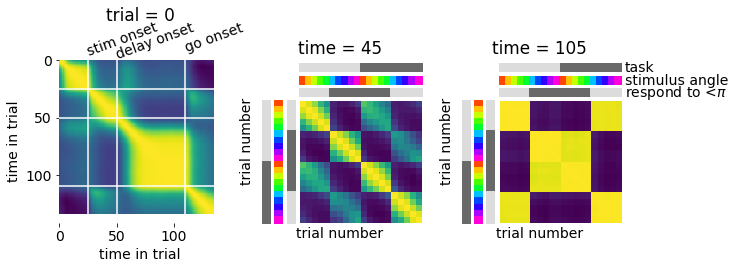

In [58]:
n_trials_show = 20

ri_set = [18,19]
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)

fig = plt.figure(figsize=(9,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,3,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,3,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True)

ax = fig.add_subplot(1,3,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True, labels=True)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

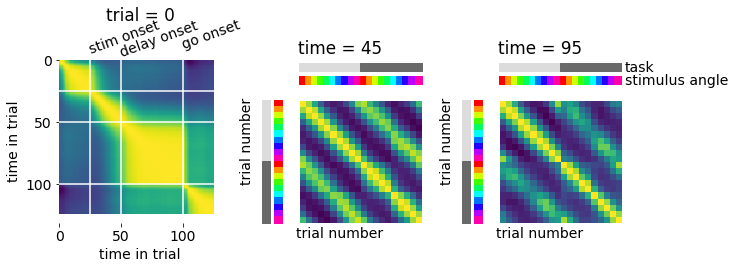

In [59]:
n_trials_show = 20

ri_set = [2,16]
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))

fig = plt.figure(figsize=(9,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,3,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,3,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False)

ax = fig.add_subplot(1,3,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False, labels=True)

In [60]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist[0]
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
#         plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize)

In [61]:
def vis_epoch_trials(ax, m, ri, epoch, D_use, n_trials_show = 20,linewidth = 12, 
       linestyle = '-', alpha = .1, markersize = 20,c_discrete = 'k'):
    rule = rules_dict['all'][ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials_show))
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    plt.sca(ax)
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
           linewidth = linewidth,linestyle = linestyle, alpha = alpha, markersize = markersize)
    plot_N(x_epoch[trial_set,:,:],D_use.T,[c_discrete,],linewidth = linewidth/3, 
           linestyle = linestyle, alpha = .8, markersize = markersize/2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(epoch[:-1] + ' epoch h')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

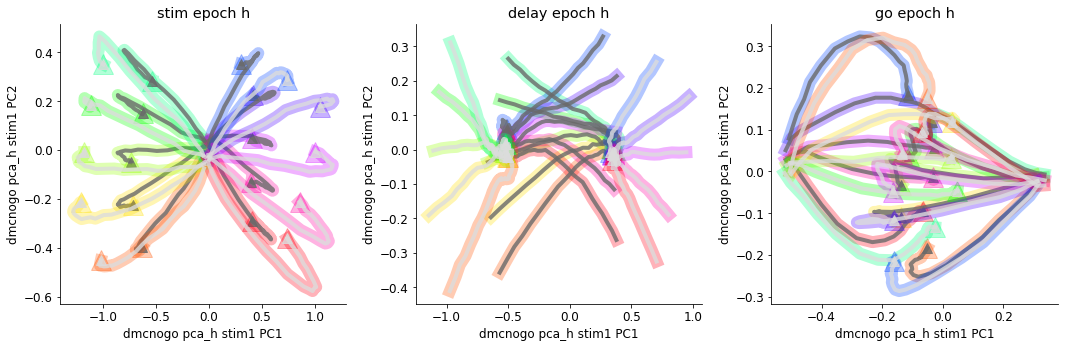

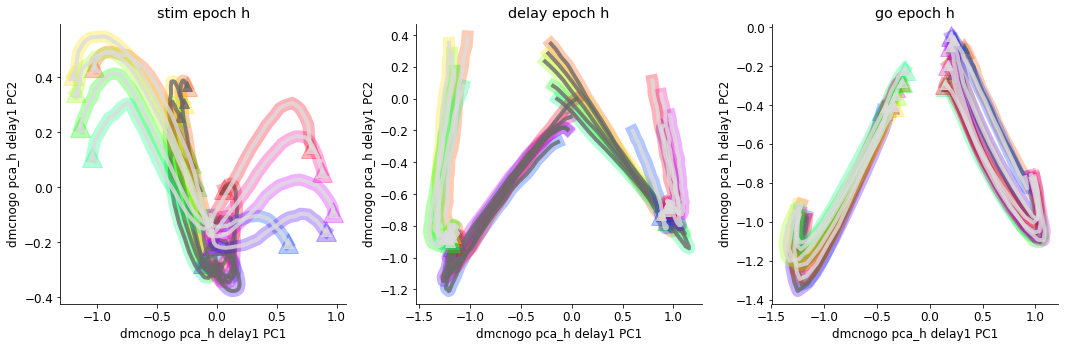

In [62]:
e_set = ['stim1','delay1','go1']
ri_set = [18,19]
trial_num = [0,0]
n_epochs = len(e_set)

axes_ri = ri_set[1]
rule = rules_dict['all'][axes_ri]
axes_epoch = 'stim1'
axs = 'pca_h'
n_trials_show = 10
c_discrete = ['dimgray','gainsboro']

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
f = get_single_task_fp_filename(trial,axes_epoch,trial_num[0])
filename = os.path.join(save_dir,f+'.npz')

for axes_epoch in ['stim1','delay1']:
    
    D_use = make_FP_axs(filename, m, rules_dict['all'][axes_ri], axes_epoch, axs = axs, clust = 'False')
    
    fig = plt.figure(figsize=(n_epochs*5,5),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 12})

    for ei_ind in range(n_epochs):

        epoch = e_set[ei_ind]
        ax = fig.add_subplot(1,n_epochs,ei_ind+1)

        for ri_ind in range(len(ri_set)):

            vis_epoch_trials(ax, m, ri_set[ri_ind], epoch, D_use, n_trials_show = n_trials_show,linewidth = 12, 
                   linestyle = '-', alpha = .3, markersize = 20,c_discrete = c_discrete[ri_ind])
            ax.set_xlabel(rules_dict['all'][axes_ri]+ ' ' + axs + ' ' + axes_epoch + ' PC1')
            ax.set_ylabel(rules_dict['all'][axes_ri]+ ' ' + axs + ' ' + axes_epoch + ' PC2')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

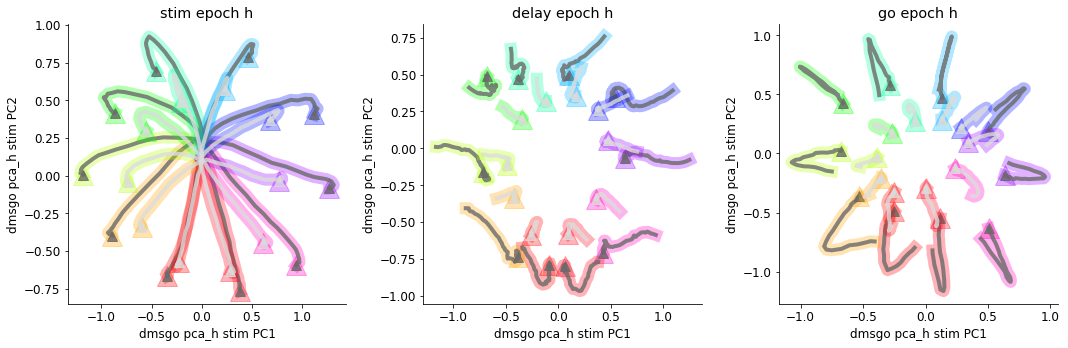

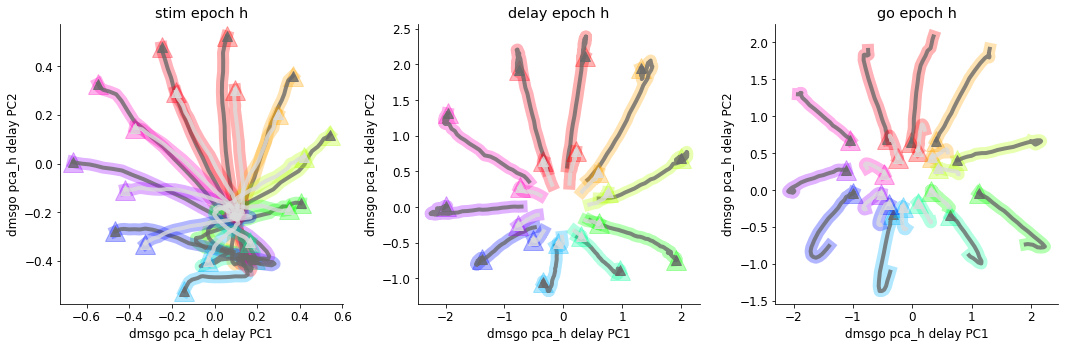

In [63]:
e_set = ['stim1','delay1','go1']
ri_set = [16,2]
n_epochs = len(e_set)
n_trials_show = 10
c_discrete = ['dimgray','gainsboro']

axes_ri = ri_set[0]
axs = 'pca_h'

trial = gen_trials_from_model_dir(m,rules_dict['all'][axes_ri],noise_on = False)
save_dir = os.path.join(m,'tf_fixed_pts_all_init',rules_dict['all'][axes_ri])
f = get_single_task_fp_filename(trial,e_set[0],0)
filename = os.path.join(save_dir,f+'.npz')

for axes_epoch in ['stim1','delay1']:
    
    D_use = make_FP_axs(filename, m, rules_dict['all'][axes_ri], axes_epoch, axs = axs, clust = 'False')
    
    fig = plt.figure(figsize=(n_epochs*5,5),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 12})

    for ei_ind in range(n_epochs):

        epoch = e_set[ei_ind]
        ax = fig.add_subplot(1,n_epochs,ei_ind+1)

        for ri_ind in range(len(ri_set)):

            vis_epoch_trials(ax, m, ri_set[ri_ind], epoch, D_use, n_trials_show = n_trials_show,linewidth = 12, 
                   linestyle = '-', alpha = .3, markersize = 20,c_discrete = c_discrete[ri_ind])
            ax.set_xlabel(rules_dict['all'][axes_ri]+ ' ' + axs + ' ' + axes_epoch[:-1] + ' PC1')
            ax.set_ylabel(rules_dict['all'][axes_ri]+ ' ' + axs + ' ' + axes_epoch[:-1] + ' PC2')

In [64]:
model = Model(m)
rule = task_list[0]
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [65]:
from network import get_perf
def init_from_other_task(ri_set,init_from,run_from,trial_offset = 0):

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    trial_set = [trial1,trial2]

    rule = rules_dict['all'][ri_set[run_from]]
    trial = trial_set[run_from]
    epoch = 'go1'
    B = np.shape(trial.x)[1]
    N = hparams['n_rnn']

    _,h = gen_X_from_model_dir(m,trial_set[init_from])
    T_inds = get_T_inds(trial,epoch)

    y_hat = np.zeros((len(T_inds),B,3))
    for ti in range(B):

        h0 = h[:,(ti+trial_offset)%B,T_inds[0]]
        x_t = trial.x[T_inds[1:],ti,:]
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
        y_hat[:,ti,:] = out_affine(params, h_t.T).T

    y_loc = trial.y_loc[T_inds,:]
    return get_perf(y_hat, y_loc)

In [66]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [2,16]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['run'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [2,16]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['run'] = 0
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [2,19]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['run'] = 0
p_ins['Init from Other Motif']['id'] = 2

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

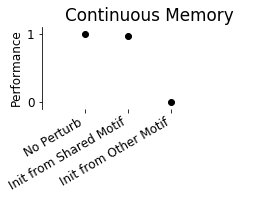

In [67]:
fig = plt.figure(figsize=(4,3),tight_layout=True,facecolor='white')
ax = plt.subplot(111)
plt.rcParams.update({'font.size': 14})

for key_i in range(len(p_ins.keys())):
    key = p_ins.keys()[key_i]
    perf = init_from_other_task(p_ins[key]['ri_set'],p_ins[key]['init'],p_ins[key]['run'],trial_offset = 0)

    plt.plot(p_ins[key]['id'],np.mean(perf),'ok')

plt.ylabel('Performance')
plt.title('Continuous Memory')
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [68]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [18,19]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['run'] = 0
p_ins['No Perturb']['offset'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [18,19]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['run'] = 0
p_ins['Init from Shared Motif']['offset'] = 40
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [18,2]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['run'] = 0
p_ins['Init from Other Motif']['offset'] = 40
p_ins['Init from Other Motif']['id'] = 2

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

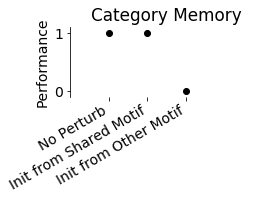

In [69]:
fig = plt.figure(figsize=(4,3),tight_layout=True,facecolor='white')
ax = plt.subplot(111)
plt.rcParams.update({'font.size': 14})

for key_i in range(len(p_ins.keys())):
    key = p_ins.keys()[key_i]
    perf = init_from_other_task(p_ins[key]['ri_set'],p_ins[key]['init'],
                                p_ins[key]['run'],trial_offset = p_ins[key]['offset'])

    plt.plot(p_ins[key]['id'],np.mean(perf),'ok')

plt.ylabel('Performance')
plt.title('Category Memory')
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [70]:
def get_filename_interp(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [71]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [72]:
def plot_FP_jitter(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',lesion_units = [],n_trials_plot = 8):
        
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        if len(lesion_units)>0:
            model.lesion_units(sess, lesion_units)
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        for rule in rule_set:
            trial = generate_trials(rule, hparams, mode='test',noise_on=False)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T,S,N = np.shape(h_tf)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

            for s in range(0,S,int(S/n_trials_plot)):

                if c_master == 'y_locs':
                    c_inds = trial.y_loc[-1,:]
                    c = cmap(c_inds[s]/(2*np.pi))
                elif c_master == 'x_locs':
                    stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
                    c = cmap(stim1_locs[s]/(2*np.pi))
                else:
                    c = c_master

                X_trial = np.dot(h_tf[T_inds,s,:],D_use)
                plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T_inds = get_T_inds(trial,fp_epoch)

        if c_master == 'y_locs':
            c_inds = trial.y_loc[-1,:]
            c = cmap(c_inds[t_num]/(2*np.pi))
        elif c_master == 'x_locs':
            stim1_locs = np.min(trial.stim_locs,axis=1)
            c = cmap(stim1_locs[t_num]/(2*np.pi))
        else:
            c = c_master

        for fp_ind in fp_inds:

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'

            else:
                markerfacecolor = c

            x_t = np.matlib.repmat(trial.x[T_inds[0],t_num,:],n_steps,1)
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = .1)

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 6,markerfacecolor = markerfacecolor)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(rule_master)

In [73]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist[0]
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
#         plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


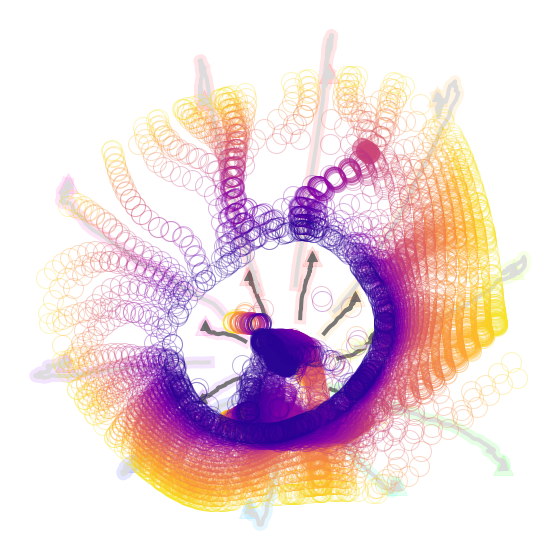

In [74]:
########## X TASK ###########

fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['delaygo','dmsgo']
# rule_set = ['dmcgo','dmcnogo']
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
# cmap_discrete = ['navy','gold']
cmap_discrete = ['dimgray','gainsboro']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0.01

if interp:
    trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
    script_name = 'interp_tasks_small_init_mov'
    save_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_filename_interp(trial1,trial2,epoch_list,t_set)
    

for ri in range(2):
    
    rule = rule_set[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    ax = plt.subplot(111)
#     plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 6, 
#            linestyle = linestyle[ri], alpha = .2, markersize = 20)
    
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
           linewidth = 12,linestyle = '-', alpha = .1, markersize = 20)
    plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 4, 
           linestyle =  '-', alpha = .9, markersize = 10)
    
#     if interp:
#     filename,_ = get_filename(trial,epoch,trial_num[ri])
#     f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
#     fp_struct = np.load(f)
#     fp_inds = fp_struct['qstar']<.001
#     sorted_fps = fp_struct['xstar'][fp_inds,:]
#     J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
#     eig_decomps = comp_eig_decomp(J_xstar)
#     fp_inds = range(len(eig_decomps))

#     plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
#                rand_step_coef = rand_step_coef, al = .8, linestyle = '-', n_steps = 30, 
#                    n_jit = 5,c_master = cmap_discrete[ri],n_trials_plot = 10)
    
if interp:
    for step_i in range(n_interp-1,0,-1):
        c = cmap_grad(step_i/n_interp)

        fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(fp_dir)
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<.001)[0]
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)
        
        for fp_ind in range(len(fp_inds)):

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'
                al = .3

            else:
                markerfacecolor = c
                al = .5

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 20,markerfacecolor = markerfacecolor,
                     alpha = al)

        
tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
# plt.title(tit,fontsize = 18)
# plt.xlabel(axes_label1,fontsize = 18)
# plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
# plt.xlim((-5,13))
# plt.ylim((-8,10))

# if not os.path.exists(os.path.join(figpath,step_file)):
#     os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
# plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
# plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


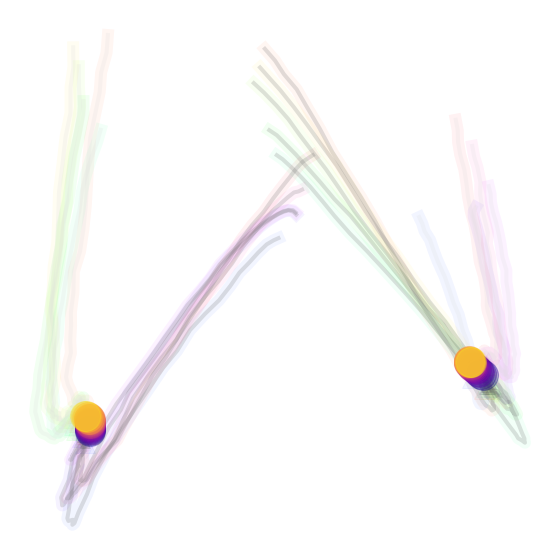

In [78]:
########## X TASK ###########

fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmcgo','dmcnogo']
# rule_set = ['dmcgo','dmcnogo']
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
# cmap_discrete = ['navy','gold']
cmap_discrete = ['dimgray','gainsboro']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0.01

if interp:
    trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
    script_name = 'interp_tasks_small_init_mov'
    save_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_filename_interp(trial1,trial2,epoch_list,t_set)
    

for ri in range(2):
    
    rule = rule_set[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    ax = plt.subplot(111)
    
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
           linewidth = 12,linestyle = '-', alpha = .05, markersize = 20)
    plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 4, 
           linestyle =  '-', alpha = .2, markersize = 10)
    
if interp:
    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(fp_dir)
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<.001)[0]
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)
        
        for fp_ind in range(len(fp_inds)):

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'
                al = .3

            else:
                markerfacecolor = c
                al = .3

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 30,markerfacecolor = markerfacecolor,
                         alpha = al)

        
tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
# plt.title(tit,fontsize = 18)
# plt.xlabel(axes_label1,fontsize = 18)
# plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
# plt.xlim((-5,13))
# plt.ylim((-8,10))

# if not os.path.exists(os.path.join(figpath,step_file)):
#     os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
# plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
# plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [ ]:
# ########## X TASK ###########
# n_interp = 20

# offset = 0
# t_set = [offset, offset]
# trial_num = [int(offset/4), int(offset/4)]

# rule_set = ['dmcgo','dmcnogo']
# epoch_set = ['delay1','delay1']
# step_file = 'interp_tasks'
# linestyle = ['-','-']
# axs = 'pca_fp'
# tol_q = 1e-6
# script_name = 'interp_tasks_small_init_mov'

# trial_str = '_'.join(str(t) for t in trial_num)
# rule_str = '_'.join(str(r) for r in rule_set)


# cmap_grad = plt.get_cmap('plasma')
# cmap_discrete = ['thistle','brown']

# rule_axs = 1
# epoch = epoch_set[rule_axs]
# rule = rule_set[rule_axs]

# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
# f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
# D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
# epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
# epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
# axes_label1 = axs+' 1'
# axes_label2 = axs+' 2'
# axes_label3 = axs+' 3'

# rand_step_coef = 0
# al = .3

# ri_range = 1
# movie_inds = 60
# w_fp = 0

# for im_num in range(1,movie_inds):
#     fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
#     ax = plt.subplot(111)
    
#     for ri in range(ri_range):

#         rule = rule_set[ri]
#         epoch = epoch_set[ri]
#         c_master = cmap_discrete[ri]

#         trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#         trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

#         _,x = gen_X_from_model_dir(m,trial)
#         T_inds = get_T_inds(trial,epoch_set[ri])
#         x_epoch = np.transpose(x[:,:,T_inds[:im_num]],(1,2,0))

#         ax = plt.subplot(111)
#         plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
#                linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)

#         if w_fp:
            
# #             if im_num==1:
#             filename,_ = get_filename(trial,epoch,trial_num[ri])
#             f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
#             fp_struct = np.load(f)
#             fp_inds = fp_struct['qstar']<.001
#             sorted_fps = fp_struct['xstar'][fp_inds,:]
#             J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
#             eig_decomps = comp_eig_decomp(J_xstar)
#             fp_inds = range(len(eig_decomps))

#             plot_FP_minimal(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
#                        rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
#                            n_jit = 0,c_master = c_master)

#     #     for step_i in range(n_interp):

#     #         f = '_'.join(rule_set)+'_'+'_'.join(epoch_set)+'_x'+str(round(t_set[0],2))+'_x'+str(round(t_set[1],2))
#     #         filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],q_str,f+'_step_'+str(step_i)+'.npz')
#     #         fp_struct = np.load(filename)
#     #         step_fps = fp_struct['xstar']
#     #         fp_inds = fp_struct['qstar']<.0001

#     #         fp_project = np.dot(step_fps,D_use)
#     #         plt.plot(fp_project[fp_inds,0],fp_project[fp_inds,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp),alpha = .5)


#     tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.set_yticks([])
#     ax.set_xticks([])
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title('')
#     plt.xlim((-5,13))
#     plt.ylim((-8,10))
    
#     if w_fp:
#         movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range)+'_wfp')
#     else:
#         movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range))
        
#     if not os.path.exists(movie_dir):
#         os.makedirs(movie_dir)

#     figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
#     plt.savefig(os.path.join(movie_dir,str(im_num)+figname+'.png'))

# images = []
# for t in range(1,im_num):#T*xt):
#     filename = os.path.join(movie_dir,str(t)+figname+'.png')
#     images.append(imageio.imread(filename))
    

# imageio.mimsave(movie_dir+'/movie.gif', images)